In [1]:
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
import seaborn as sns
# data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
#sent_tokenize() method is to split a document or paragraph into sentences.
#word_tokenize() method splits a given sentence into words using the NLTK library.
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
#Label encoding is a simple and effective way to convert categorical variables into numerical form.
# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
# SVC is a specific implementation of the Support Vector Machine algorithm that is designed specifically for classification tasks.
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
#The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts.
# ### Importing the Dataset
data = pd.read_csv("spam.csv",encoding='latin1')
data.sample(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
1584,ham,"Sorry, I'll call later",NaN,NaN,NaN
2293,ham,Hello. Damn this christmas thing. I think i ha...,NaN,NaN,NaN
3501,ham,I will come to ur home now,NaN,NaN,NaN
3261,ham,O shore are you takin the bus,NaN,NaN,NaN
4331,ham,ALSO TELL HIM I SAID HAPPY BIRTHDAY,NaN,NaN,NaN


In [3]:
#initial exploration and data cleaning
data.shape
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
data.rename(columns={'v1': 'result', 'v2': 'emails'}, inplace=True)
#In-place operators allow you to perform arithmetic, logical, and bitwise operations on variables updating their values in place.
data
data.isnull().sum()
data.duplicated().sum()
data = data.drop_duplicates(keep='first')
data.shape
data.head(5)

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


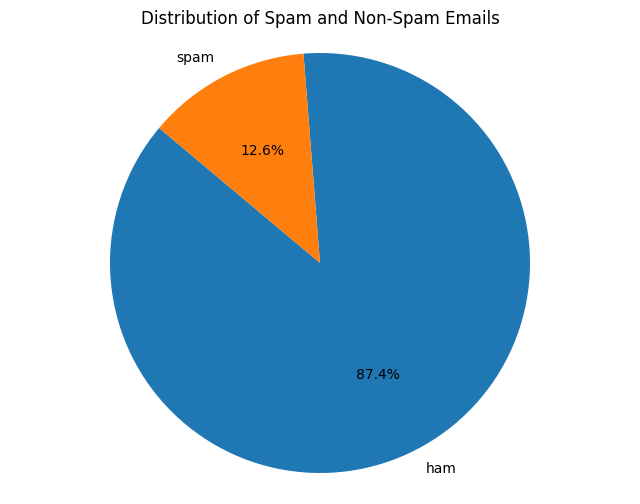

In [4]:
#EDA
data['result'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(data['result'].value_counts(), labels=data['result'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.axis('equal')
plt.show()

Average Length of Spam Emails: 137.89127105666157
Average Length of Ham Emails: 70.45925597874225


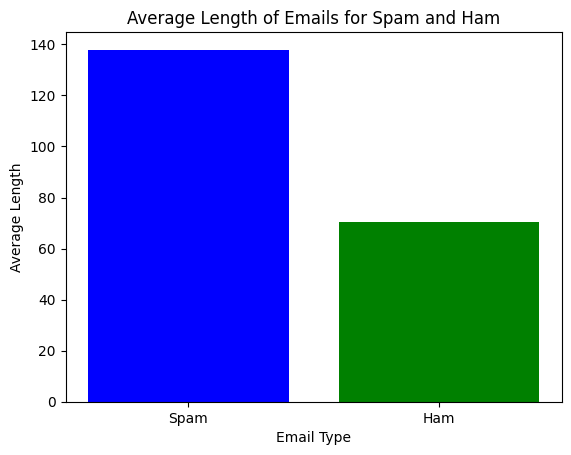

In [5]:
#Average length of emails for spam and ham
data['Length'] = data['emails'].apply(len)
data['num_words'] = data['emails'].apply(word_tokenize).apply(len)
data['num_sentence'] = data['emails'].apply(sent_tokenize).apply(len)
data.head(2)
avg_length_spam = data[data['result'] == 'spam']['Length'].mean()
avg_length_ham = data[data['result'] == 'ham']['Length'].mean()
#plotting
print("Average Length of Spam Emails:", avg_length_spam)
print("Average Length of Ham Emails:", avg_length_ham)
plt.bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['Blue', 'green'])
plt.title('Average Length of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Length')
plt.show()

Average Words of Spam Emails: 27.6676875957121
Average Words of Ham Emails: 17.12378210806023


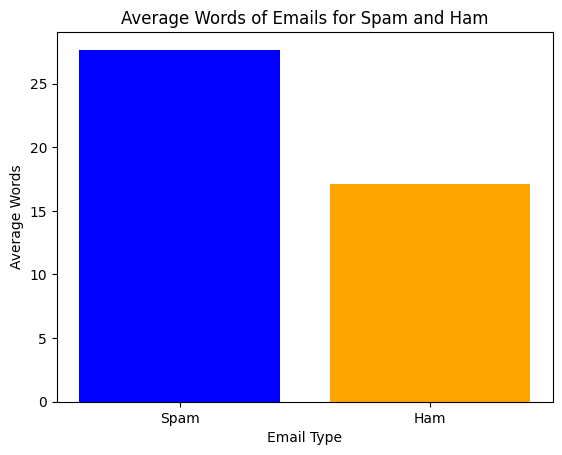

In [6]:
#Average words of email for Spam and Ham
avg_word_spam = data[data['result'] == 'spam']['num_words'].mean()
avg_word_ham = data[data['result'] == 'ham']['num_words'].mean()
print("Average Words of Spam Emails:", avg_word_spam)
print("Average Words of Ham Emails:", avg_word_ham)

# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_word_spam, avg_word_ham], color=['Blue', 'orange'])
plt.title('Average Words of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Words')
plt.show()

Average Sentence of Spam Emails: 2.970903522205207
Average Sentence of Ham Emails: 1.8201948627103632


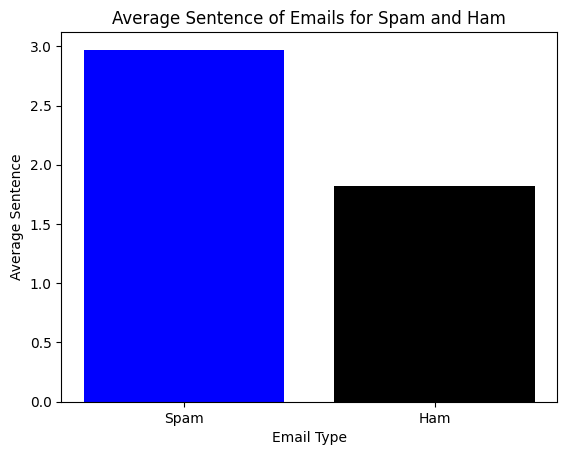

In [7]:
#Average sentences of email for Spam and Ham
avg_sentence_spam = data[data['result'] == 'spam']['num_sentence'].mean()
avg_sentence_ham = data[data['result'] == 'ham']['num_sentence'].mean()
print("Average Sentence of Spam Emails:", avg_sentence_spam)
print("Average Sentence of Ham Emails:", avg_sentence_ham)

# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_sentence_spam, avg_sentence_ham], color=['Blue', 'black'])
plt.title('Average Sentence of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Sentence')
plt.show()

Correlation coefficient between email length and spam classification: 0.38471706671430717


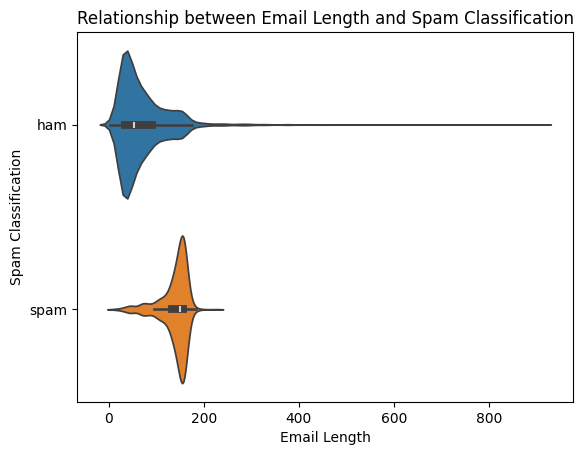

In [8]:
correlation = data['Length'].corr((data['result'] == 'spam').astype(int))
print("Correlation coefficient between email length and spam classification:", correlation)


sns.violinplot(data=data, x='Length', y='result', hue='result')
plt.xlabel('Email Length')
plt.ylabel('Spam Classification')
plt.title('Relationship between Email Length and Spam Classification')
plt.show()

In [9]:
#Data preprocessing
data['transform_text'] = data['emails'].str.lower()
# Tokenization
data['transform_text'] = data['transform_text'].apply(word_tokenize)

# Removing special characters
data['transform_text'] = data['transform_text'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in x])

# Removing stop words and punctuation
stop_words = set(stopwords.words('english'))
data['transform_text'] = data['transform_text'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])

# Stemming
ps = PorterStemmer()
data['transform_text'] = data['transform_text'].apply(lambda x: [ps.stem(word) for word in x])

# Convert the preprocessed text back to string
data['transform_text'] = data['transform_text'].apply(lambda x: ' '.join(x))

# Display the preprocessed data
print(data[['emails', 'transform_text']].head())


                                              emails  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                      transform_text  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri 2 wkli comp win fa cup final tkt 21...  
3                u dun say earli hor u c alreadi say  
4            nah nt think goe usf live around though  


Top 10 Most Common Words in Spam Emails:
call: 321 occurrences
free: 191 occurrences
2: 157 occurrences
txt: 141 occurrences
u: 135 occurrences
text: 122 occurrences
ur: 119 occurrences
mobil: 114 occurrences
stop: 106 occurrences
repli: 103 occurrences


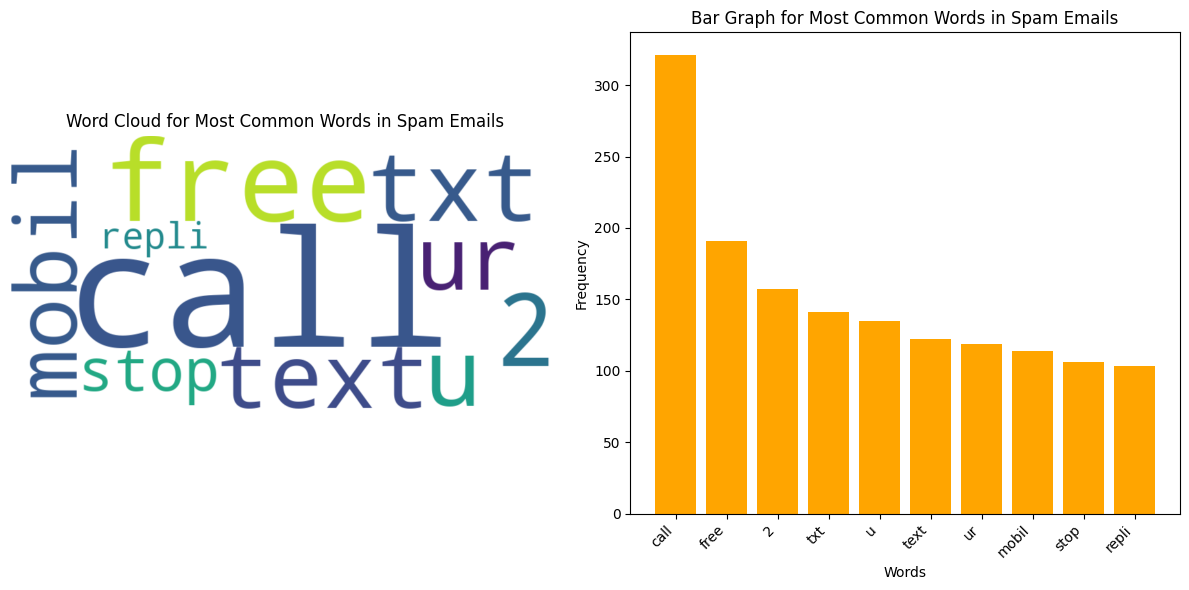

In [10]:
#Word Cloud for Most Common Words in ham Emails
spam_emails = data[data['result'] == 'spam']['transform_text']
# Tokenize the text in spam emails
spam_words = ' '.join(spam_emails).split()
# Count occurrences of each word
word_counts = Counter(spam_words)
# Find the most common words
most_common_words = word_counts.most_common(10)
print("Top 10 Most Common Words in Spam Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")
    # Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))
# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Spam Emails')
plt.axis('off')
# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in Spam Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Top 10 Most Common Words in ham Emails:
u: 904 occurrences
go: 404 occurrences
nt: 352 occurrences
get: 352 occurrences
2: 290 occurrences
gt: 288 occurrences
lt: 287 occurrences
come: 275 occurrences
ok: 251 occurrences
got: 238 occurrences


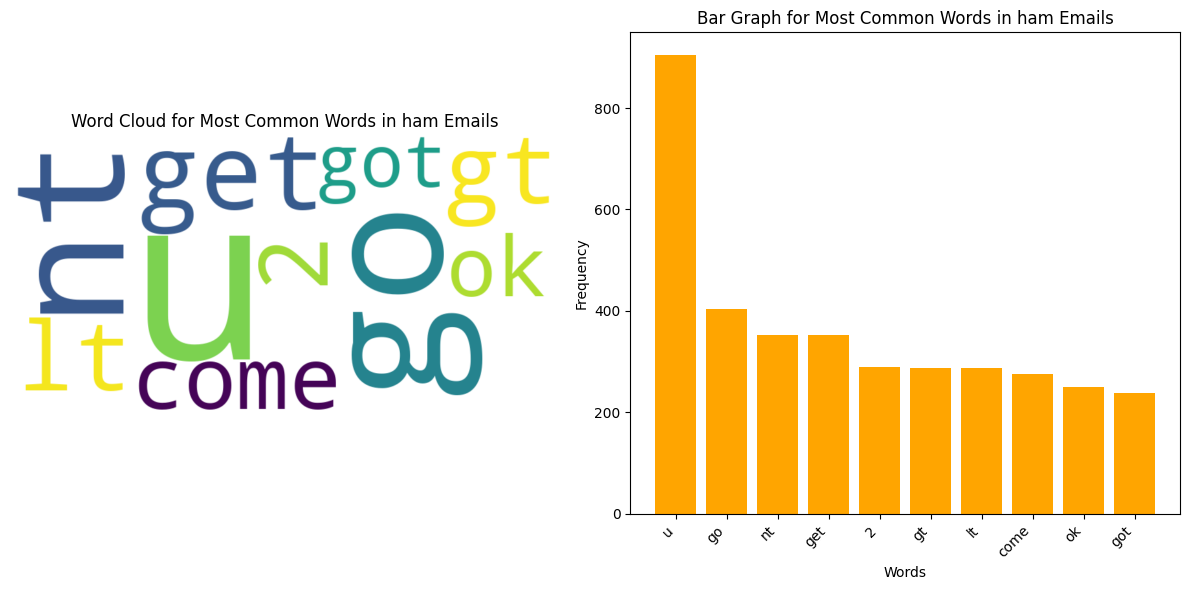

In [11]:
#Word Cloud for Most Common Words in ham Emails
ham_emails = data[data['result'] == 'ham']['transform_text']
# Tokenize the text in spam emails
ham_words = ' '.join(ham_emails).split()
# Count occurrences of each word
word_counts = Counter(ham_words)
# Find the most common words
most_common_words = word_counts.most_common(10)

print("Top 10 Most Common Words in ham Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")
    # Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))
# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in ham Emails')
plt.axis('off')
# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in ham Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
#Preparing Data for Machine Learning: Label Encoding and Vectorization”
encoder = LabelEncoder()
data['result'] = encoder.fit_transform(data['result'])
data.sample(2)

#data spliting and vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['emails']).toarray()
y = data['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)